In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
 
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 40
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set the drawing style and color palette for the seaborn library
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(COLORS))

# Set the default graphic size for matplotlib
rcParams['figure.figsize'] = 12, 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# get the infomation of data
df = pd.read_csv("D:/Codefield/CODE_PYTHON/NLP/Prob1/ABSA/Laptop_Train_v2.csv")
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358 entries, 0 to 2357
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2358 non-null   int64 
 1   text      2358 non-null   object
 2   term      2358 non-null   object
 3   polarity  2358 non-null   object
 4   from      2358 non-null   int64 
 5   to        2358 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 110.7+ KB


In [3]:
def to_sentiment(polarity):
    polarity = str(polarity)
    if polarity == 'negative':
        return 0
    elif polarity == 'neutral':
        return 1
    elif polarity == 'positive':
        return 2
    else:
        return 3

MAX_LEN = 160

df['sentiment'] = df.polarity.apply(to_sentiment)
 
class_names = ['negative', 'neutral', 'positive', 'conflict']

PRE_TRAINED_MODEL = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [4]:
class Reviews(Dataset):
    def __init__(self, reviews, review_aspects, targets, tokenizer, max_len):
        self.reviews = reviews
        self.review_aspects = review_aspects
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
 
    def __len__(self):
        return len(self.reviews)
 
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
 
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [5]:
df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)
 
df_train.shape, df_val.shape, df_test.shape

((2122, 7), (118, 7), (118, 7))

In [6]:
def data_loader(df, tokenizer, max_len, batch_size):
    ds = Reviews(
        reviews = df.text.to_numpy(),
        review_aspects = df.term.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )
 
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )
 
BATCH_SIZE = 4
 
train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [7]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
D:\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [8]:
data = next(iter(train_data_loader))

data.keys()
data['input_ids'].shape
data['attention_mask'].shape
data['targets'].shape
data['input_ids']

tensor([[  101,  1192,  1169,  1256,  1576,   170, 21287,  2076,  1788,  3253,
          1105,  1576,  1251,  1286,  5909,  7054,  3594,  1115,  1128,  7284,
          2834,  1129,  1443,   119,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [9]:
class SentimentClassifier(nn.Module):
 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL, output_hidden_states=True, output_attentions=True, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
 
    def forward(self, input_ids, attention_mask):
        _, pooled_output,_,_ = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [10]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
EPOCHS = 10
 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
 
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
 
loss_fn = nn.CrossEntropyLoss().to(device)

D:\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
  ):
    model = model.train()
 
    losses = []
    correct_predictions = 0
 
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
 
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
 
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
 
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
 
    return correct_predictions.double() / n_examples, np.mean(losses)

In [13]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
 
    losses = []
    correct_predictions = 0
 
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
 
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
 
            loss = loss_fn(outputs, targets)
 
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
 
    return correct_predictions.double() / n_examples, np.mean(losses)

In [14]:
%%time
 
history = defaultdict(list)
best_accuracy = 0
 
for epoch in range(EPOCHS):
 
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
 
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
 
    print(f'Train loss {train_loss} accuracy {train_acc}')
 
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
 
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
 
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
 
    if val_acc >= best_accuracy:
        torch.save(model.state_dict(), 'best_model_laptop.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.9396579184353688 accuracy 0.6588124410933082
Val   loss 0.7005788765847683 accuracy 0.7542372881355932

Epoch 2/10
----------
Train loss 0.7400125541106891 accuracy 0.7902921771913289
Val   loss 0.7082347464437286 accuracy 0.7796610169491526

Epoch 3/10
----------
Train loss 0.6379464731517506 accuracy 0.8308199811498587
Val   loss 0.8145487868382285 accuracy 0.8050847457627118

Epoch 4/10
----------
Train loss 0.5353097633678788 accuracy 0.8685202639019792
Val   loss 0.8671208761322001 accuracy 0.7796610169491526

Epoch 5/10
----------
Train loss 0.4769877467397425 accuracy 0.8774740810556079
Val   loss 0.9056394291964049 accuracy 0.7627118644067796

Epoch 6/10
----------
Train loss 0.4289080798215971 accuracy 0.8854853911404336
Val   loss 1.0668788654768528 accuracy 0.7542372881355932

Epoch 7/10
----------
Train loss 0.3743746996089455 accuracy 0.8967954759660698
Val   loss 1.1972869061050004 accuracy 0.7711864406779662

Epoch 8/10
----------
Train

In [15]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
 
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 160])
torch.Size([4, 160])


In [17]:
history['train_acc']

[tensor(0.6588, dtype=torch.float64),
 tensor(0.7903, dtype=torch.float64),
 tensor(0.8308, dtype=torch.float64),
 tensor(0.8685, dtype=torch.float64),
 tensor(0.8775, dtype=torch.float64),
 tensor(0.8855, dtype=torch.float64),
 tensor(0.8968, dtype=torch.float64),
 tensor(0.9025, dtype=torch.float64),
 tensor(0.9043, dtype=torch.float64),
 tensor(0.9100, dtype=torch.float64)]

In [18]:
history['val_acc']

[tensor(0.7542, dtype=torch.float64),
 tensor(0.7797, dtype=torch.float64),
 tensor(0.8051, dtype=torch.float64),
 tensor(0.7797, dtype=torch.float64),
 tensor(0.7627, dtype=torch.float64),
 tensor(0.7542, dtype=torch.float64),
 tensor(0.7712, dtype=torch.float64),
 tensor(0.7627, dtype=torch.float64),
 tensor(0.7627, dtype=torch.float64),
 tensor(0.7712, dtype=torch.float64)]

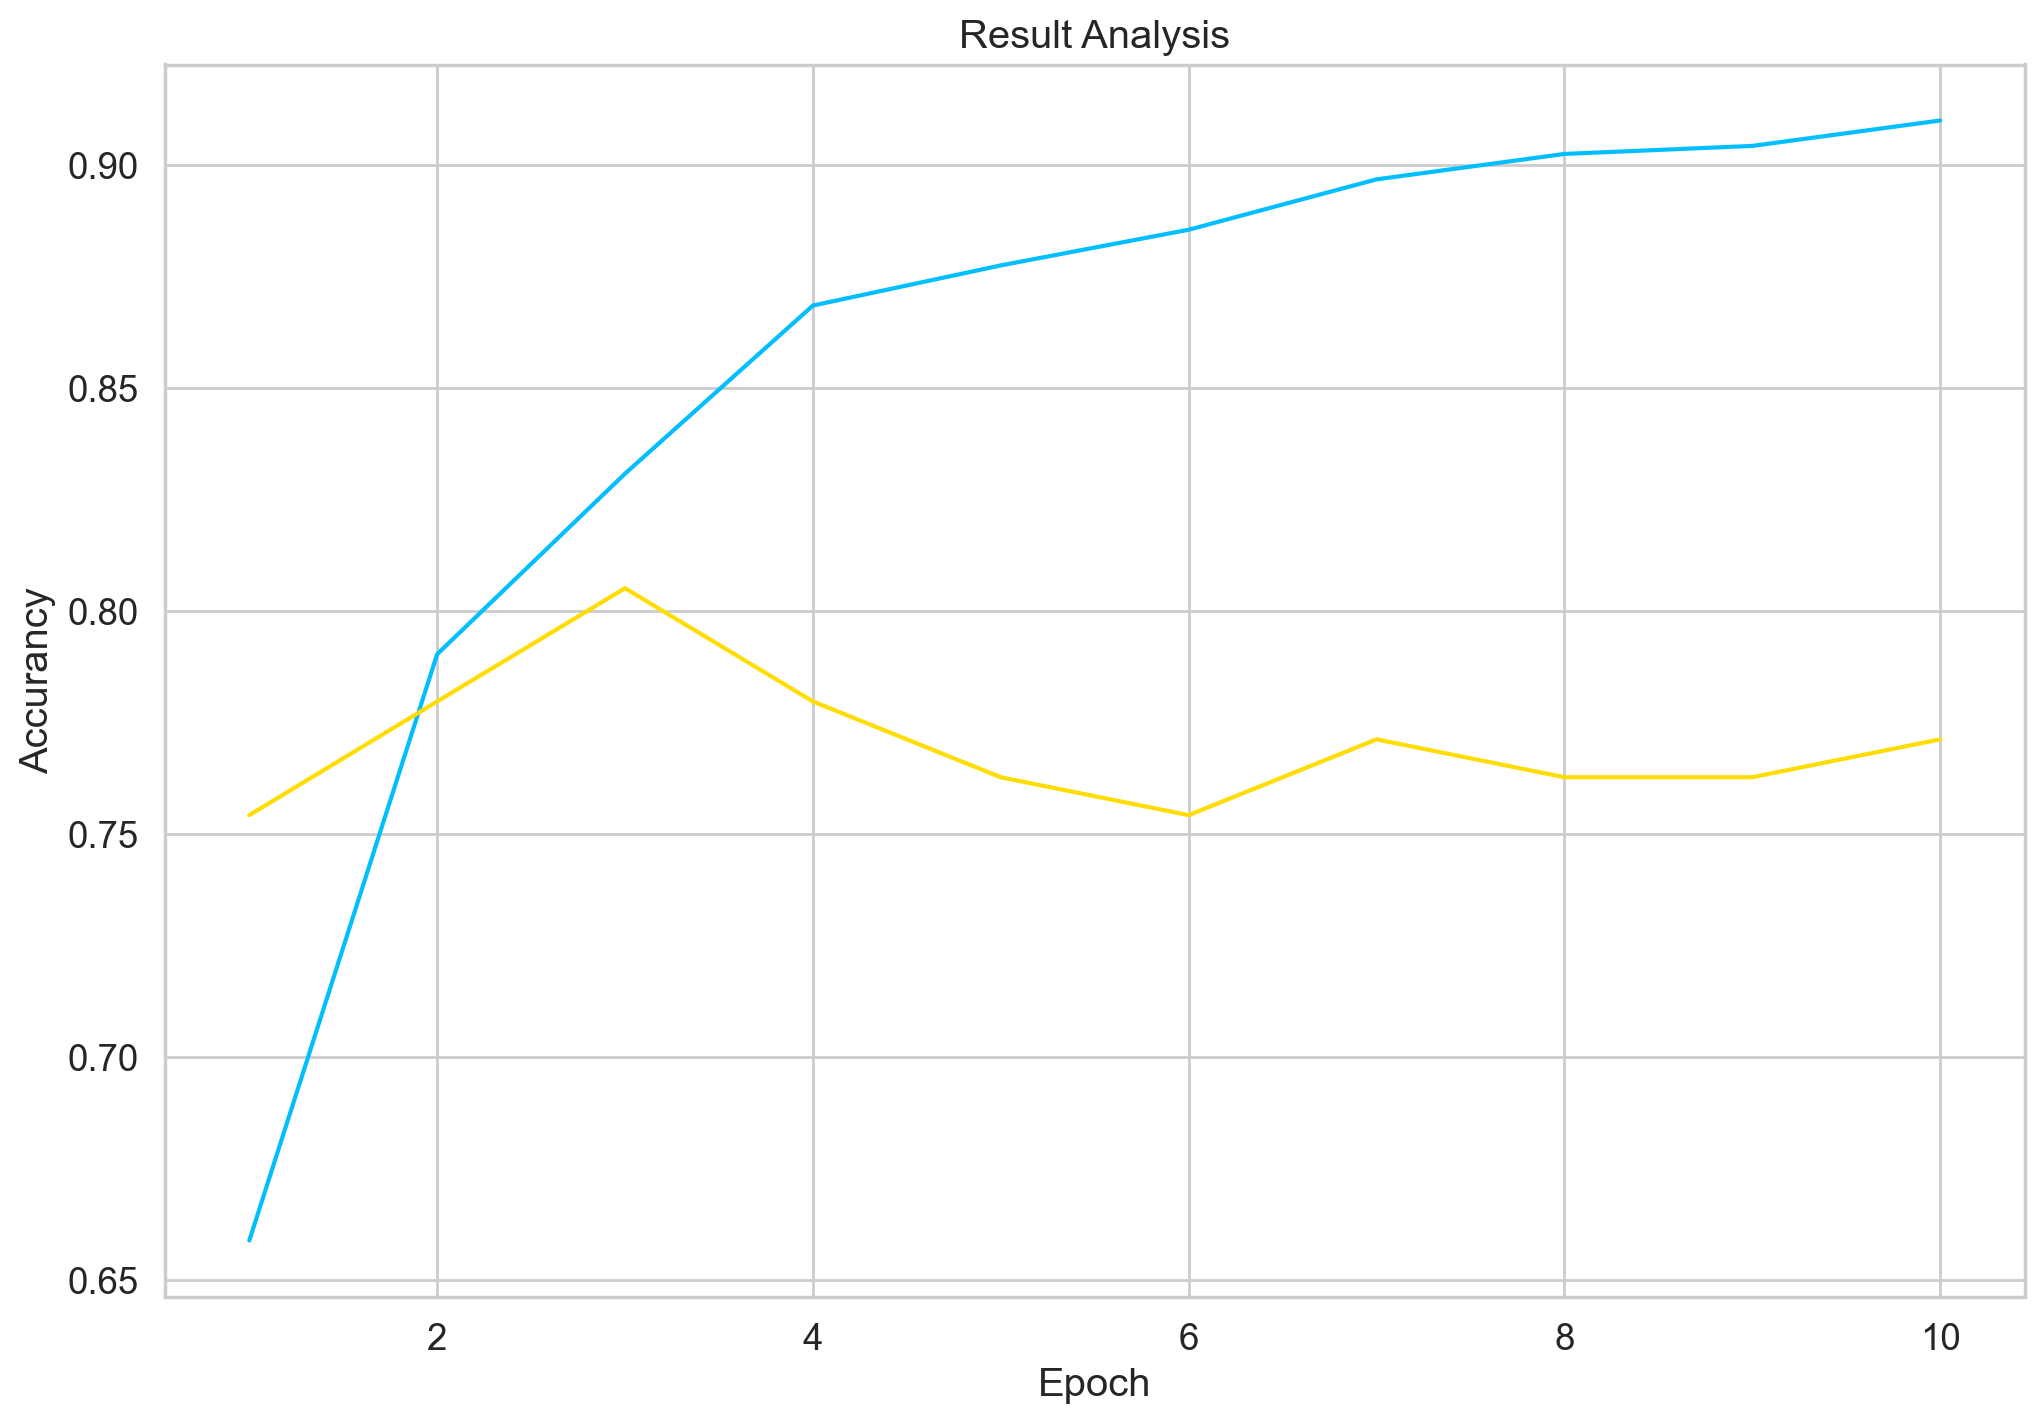

In [26]:
import matplotlib.pyplot as plt

y = [0.6588, 0.7903, 0.8308, 0.8685, 0.8775, 0.8855, 0.8968, 0.9025, 0.9043, 0.9100]
z = [0.7542, 0.7797, 0.8051, 0.7797, 0.7627, 0.7542, 0.7712, 0.7627, 0.7627, 0.7712]
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.plot(x, y, label='train_acc')
plt.plot(x, z, label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accurancy')
plt.title('Result Analysis')
plt.show()


In [19]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_laptop.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)
test_acc.item()

0.7542372881355932

In [21]:
def predict(model, data_loader):
    model = model.eval()
 
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
 
    with torch.no_grad():
        for d in data_loader:
 
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
 
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
 
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
 
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [22]:
# test 1
y_review_texts, y_pred, y_pred_probs, y_test = predict(
    model,
    test_data_loader
)

idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
})
 
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

(No problem with the ordering or shipping by the way.

True sentiment: positive


In [27]:
# test 2
review_text = "I think the computer is not as good as it says."

encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
 
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
 
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I think the computer is not as good as it says.
Sentiment  : negative
